In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import tensorflow as tf
import numpy as np
import pickle
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score
from datapipe import bin_ndarray, calcDff
from sklearn.externals import joblib
#TODO: read tf documentation on what the static_rnn does
#do I want to one hot encode the data? or already too many dimensions

In [2]:
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
np.random.seed(0)

In [4]:
tf.__version__
from tensorflow.python.ops import control_flow_ops

orig_while_loop = control_flow_ops.while_loop

def patched_while_loop(*args, **kwargs):
    kwargs.pop("maximum_iterations", None)  # Ignore.
    return orig_while_loop(*args, **kwargs)


control_flow_ops.while_loop = patched_while_loop

In [697]:
#loading full file on disk, can access small slices without loading into memory
dy = np.load("./data/whisk_encoded_dfnobg2.npy", mmap_mode='r')
# dy = process_dy(dy)
# dy = calcDff(dy, .2, 30)
f = open('./data/masdfAV_2.pkl', 'rb')
df = pickle.load(f)
(length, y, x, channels) = dy.shape
print(length, x, y, channels)

52478 11 7 14


In [ ]:
#10hz data
dfcropped = (df.iloc[::3])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped= (dy[::3])
(length, leny, lenx) = dycropped.shape
dycropped = dycropped.reshape(length, leny*lenx)

In [162]:
#15hz data
dfcropped = (df.iloc[::2])
dfcropped = dfcropped[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]

dycropped = (dy[::2])
(length, leny, lenx) = dycropped.shape
dycropped = dycropped.reshape(length, leny*lenx)

In [1077]:
#30hz data 
dfcropped = df[["stimType", "pupilCurr", "snoutCurr","jawCurr","wheelCurr","responseT", "H", "M", "FA", "CR",
                 "whiskCurr", "lastStimT","vidCurr"]]
(length, leny, lenx, channel) = dy.shape

# dycropped = dy.reshape((length, leny*lenx))
dycropped = dy.reshape((length, leny*lenx*channel))
print(dycropped.shape)

(52478, 1078)


In [1078]:
me = np.load("./data/whisk_me.npy")
thres = np.std(me)*1.5
avg = np.average(me)
print(thres)
y_data = np.zeros(len(df))
prev = me[0]
for valiter, val in enumerate(me):
    if abs(val-prev) >= thres:
        y_data[valiter] = 1
    prev = val
print(len(y_data))
sum(y_data)  

22.439677537994466
52478


12263.0

In [1079]:
x_data = dycropped
print("Shape:", x_data.shape)

Shape: (52478, 1078)


In [1080]:
print(type(dycropped))
print("Shape:", dycropped.shape)

<class 'numpy.core.memmap.memmap'>
Shape: (52478, 1078)


In [1081]:
num_data = len(x_data)
print(num_data)
train_split = 0.7
validation_split = 0.1
num_train = int(train_split*num_data)
num_val = int((num_data - num_train)*validation_split)
num_test = num_data - num_train - num_val

52478


In [1082]:
x_train = x_data[0:num_train]
x_val = x_data[num_train:(num_train+num_val)]
x_test = x_data[(num_train+num_val):]
len(x_train) + len(x_test)

50904

In [1083]:
y_train = y_data[0:num_train]
y_val = y_data[num_train:(num_train+num_val)]
y_test = y_data[(num_train+num_val):]
len(y_train) + len(y_test)
len(y_train) + len(y_test)

50904

In [1084]:
num_x_signals = x_data.shape[1]
num_x_signals
num_y_signals = 1
num_y_signals

1

# Scaled Data

In [1085]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 885.85486


In [1086]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
# joblib.dump(x_scaler, "x_scaler30hz.pkl")

In [1087]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.000001


In [1088]:
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

In [1089]:
x_test_scaled = x_scaler.transform(x_test)
x_val_scaled = x_scaler.transform(x_val)

In [1090]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))
y_val_scaled = y_scaler.transform(y_val.reshape(-1,1))
# joblib.dump(y_scaler, "y_scaler10hz.pkl")
y_train_scaled

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

# Data Generator
useful for large amounts of data

In [1091]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
#         y_shape = (batch_size, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [1092]:
batch_size = 64
sequence_length = 40 #20 frames after stim time i dont think this right come back to it

In [1093]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [1094]:
x_batch, y_batch = next(generator)

In [1095]:
print(x_batch.shape)
print(y_batch.shape)

(64, 40, 1078)
(64, 40, 1)


In [1096]:
validation_data = (np.expand_dims(x_val_scaled, axis=0),
                   np.expand_dims(y_val_scaled, axis=0))

In [1097]:
#make this dense layer bigger
model = Sequential()
model.add(LSTM(units=3,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
# model.add(LSTM(units=24,
#               return_sequences=True,
#               input_shape=(None, num_x_signals,)))
# model.add(Dense(250, activation='sigmoid'))
# model.add(Dropout(.30))
# model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(.40))
model.add(Dense(1500, activation='sigmoid'))
model.add(Dropout(.40))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dropout(.40))

In [1098]:
# squash the outputs to be between 0 and 1
model.add(Dense(num_y_signals, activation='sigmoid'))


A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid NaN values during training. You may need to experiment with this to get it working.

In [1099]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

# Loss Function

In [1100]:
warmup_steps = 2

In [1101]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [1102]:
optimizer = RMSprop(lr=1e-3)

In [1103]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [1104]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, None, 3)           12984     
_________________________________________________________________
dropout_109 (Dropout)        (None, None, 3)           0         
_________________________________________________________________
dense_129 (Dense)            (None, None, 1500)        6000      
_________________________________________________________________
dropout_110 (Dropout)        (None, None, 1500)        0         
_________________________________________________________________
dense_130 (Dense)            (None, None, 1000)        1501000   
_________________________________________________________________
dropout_111 (Dropout)        (None, None, 1000)        0         
_________________________________________________________________
dense_131 (Dense)            (None, None, 1)           1001      
Total para

In [1105]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [1106]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [1107]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [1108]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [1109]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [1110]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 12s 115ms/step - loss: 0.7745 - acc: 0.6992 - val_loss: 0.5478 - val_acc: 0.7637

Epoch 00001: val_loss improved from inf to 0.54775, saving model to 23_checkpoint.keras
Epoch 2/100
100/100 [==============================] - 11s 110ms/step - loss: 0.5920 - acc: 0.7238 - val_loss: 0.6017 - val_acc: 0.6525

Epoch 00002: val_loss did not improve from 0.54775

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/100
100/100 [==============================] - 11s 110ms/step - loss: 0.5150 - acc: 0.7332 - val_loss: 0.4672 - val_acc: 0.7637

Epoch 00003: val_loss improved from 0.54775 to 0.46716, saving model to 23_checkpoint.keras
Epoch 4/100
100/100 [==============================] - 11s 109ms/step - loss: 0.4975 - acc: 0.7380 - val_loss: 0.4725 - val_acc: 0.7637

Epoch 00004: val_loss did not improve from 0.46716

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 5/100
100/100 [=

100/100 [==============================] - 11s 109ms/step - loss: 0.4332 - acc: 0.7642 - val_loss: 0.3829 - val_acc: 0.7872

Epoch 00040: val_loss did not improve from 0.37938
Epoch 41/100
100/100 [==============================] - 11s 110ms/step - loss: 0.4366 - acc: 0.7599 - val_loss: 0.3817 - val_acc: 0.7872

Epoch 00041: val_loss did not improve from 0.37938
Epoch 42/100
100/100 [==============================] - 11s 109ms/step - loss: 0.4400 - acc: 0.7586 - val_loss: 0.3778 - val_acc: 0.7897

Epoch 00042: val_loss improved from 0.37938 to 0.37776, saving model to 23_checkpoint.keras
Epoch 43/100
100/100 [==============================] - 11s 109ms/step - loss: 0.4432 - acc: 0.7564 - val_loss: 0.3776 - val_acc: 0.7878

Epoch 00043: val_loss improved from 0.37776 to 0.37758, saving model to 23_checkpoint.keras
Epoch 44/100
100/100 [==============================] - 11s 109ms/step - loss: 0.4320 - acc: 0.7635 - val_loss: 0.3770 - val_acc: 0.7872

Epoch 00044: val_loss improved from 0

In [1111]:

#82 percent train ish and 86ish percent on val 88 on test on the last saved
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 6s 6s/step


In [215]:
print(x_test_scaled.dtype)

float64


In [955]:
model.save("bestwhiskDS2.h5")

In [1112]:
print("y_val")
print(sum(y_val_scaled))
print(len(y_val_scaled))
print("y_train")
print(sum(y_train_scaled))
print(len(y_train_scaled))
print("y_test")
print(len(y_test_scaled))
print(sum(y_test_scaled))
print("loss (test-set):", result)
pred = model.predict(x=np.expand_dims(x_test_scaled, axis=0))
predT = pred[pred>=.5]
print(model.predict(x=np.expand_dims(x_test_scaled, axis=0)))

y_val
[372.]
1574
y_train
[9447.]
36734
y_test
14170
[2444.]
loss (test-set): [0.31843075156211853, 0.8311223983764648]
[[[0.0763614 ]
  [0.032134  ]
  [0.02591723]
  ...
  [0.02294387]
  [0.02306422]
  [0.02332327]]]


In [1113]:
pred_train = model.predict(x=np.expand_dims(x_train_scaled, axis=0))

In [1114]:
pred_val = model.predict(x=np.expand_dims(x_val_scaled, axis=0))

In [1115]:
pred_test = model.predict(x=np.expand_dims(x_test_scaled, axis=0))

In [1116]:
#TODO comeback and make this useful for my data
def plot_images(images, cls_pred=None):
    
    #Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape((123,130)).astype(np.float32))
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

[0.09556117]


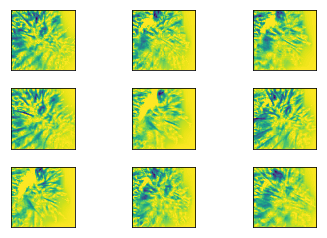

In [1117]:
print(pred_train[0][-0])
realImg = np.load('./data/whisk_df_nb2.npy', mmap_mode='r')
images = realImg[num_train-9:num_train]
plot_images(images=images)

91.57773608505316
113.14565353345841
91.57773608505316
120.21494684177611


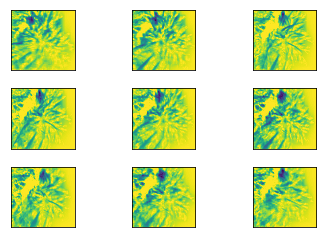

In [1144]:
images = realImg[880:889]
print(np.average(abs((realImg[153]-realImg[152]))))
print(me[152])
print(me[153])
print(me[154])
plot_images(images=images)

52478


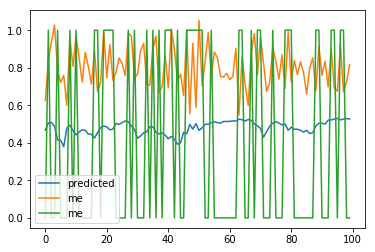

In [1142]:
answers = np.append(np.append(pred_train, pred_val), pred_test)
print(len(answers))
plt.plot(answers[800:900], label="predicted")
plt.plot(np.divide(me[800:900],140), label="me")
plt.plot(np.divide(y_train_scaled[800:900],1), label="me")
plt.legend()
plt.show()

In [1135]:
print(len(predT))
print(sum(y_test_scaled))
# np.save('./data/whiskingpb.npy', answers)

707
[2444.]


In [149]:
def r2_keras(y_true, y_pred):
    SS_res =  np.sum(np.square(np.subtract(y_true,y_pred))) 
    print(SS_res)
    SS_tot = np.sum(np.square(np.subtract(y_true, np.mean(y_true)))) 
    print(SS_tot)
    return ( 1 - SS_res/(SS_tot))

In [150]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train_scaled
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test_scaled
#         x = x_val_scaled
#         y_true = y_val_scaled
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print("y_pred")
    print(y_pred.dtype)
    print(y_true.dtype)
    y_true = y_true.astype(np.float32)
    sum_pred = []
    sum_true = []
 
    # For each output-signal.
    for i in range(len(x[0])):
        sum_pred.append(np.sum(y_pred[0][i])/(lenx*leny))
        sum_true.append(np.sum(y_true[i])/(lenx*leny))
    # Plot and compare the two signals.
    plt.plot(sum_true, label='true')
    plt.plot(sum_pred, label='pred')
    print("r2")
    print(r2_keras(y_true, y_pred[0]))
    print(r2_score(y_true, y_pred[0], multioutput='uniform_average'))
    print(explained_variance_score(y_true, y_pred[0],multioutput='uniform_average'))
    # Plot grey box for warmup-period.


    # Plot labels etc.
    plt.ylabel("sum")
    plt.legend()
    plt.show()

y_pred
float32
float32
r2
916915.4
1554867.1
0.4102934002876282
-0.25820514852092247
0.11379470034844458


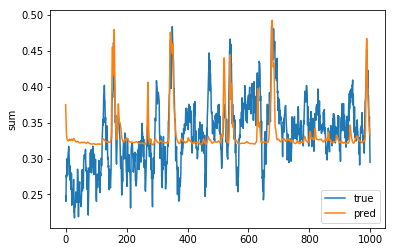

In [151]:
plot_comparison(start_idx=2, length=1000, train=False)